In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


In [3]:
# 2. Load Dataset
df = pd.read_csv('/Users/vyadav/Downloads/GlobalTemperatures.csv')
df.head()


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 3. Convert date and set as index
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)

# 4. Select useful column and drop missing
df = df[['LandAverageTemperature']].copy()
df = df.dropna()


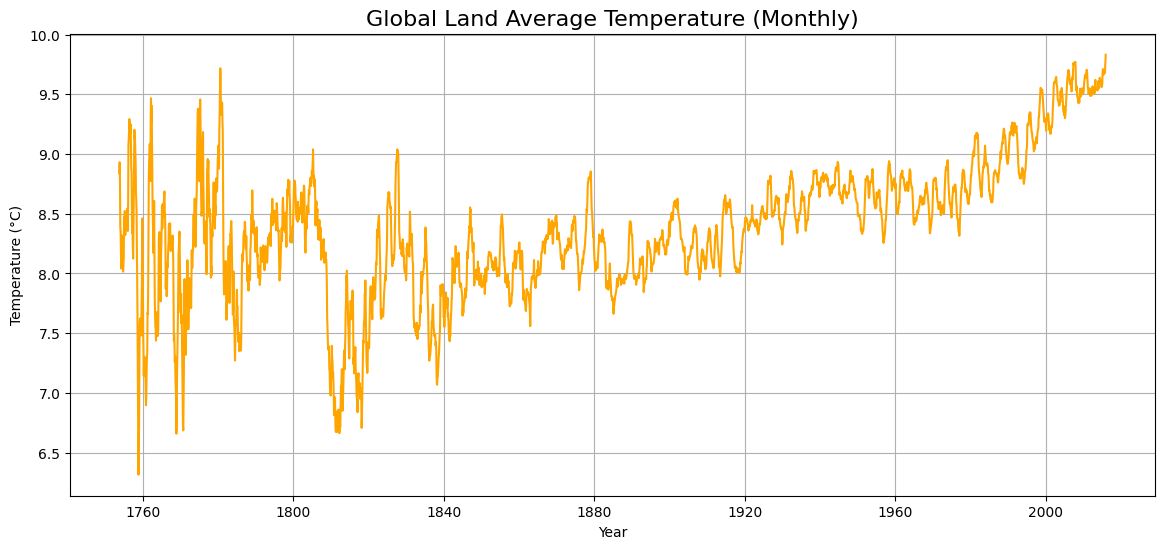

In [5]:
# 5. Resample monthly and calculate mean
monthly_temp = df['LandAverageTemperature'].resample('M').mean()

# 6. Smooth out data (optional)
monthly_temp = monthly_temp.rolling(window=12).mean()

# 7. Plot the smoothed data
plt.figure(figsize=(14,6))
plt.plot(monthly_temp, color='orange')
plt.title('Global Land Average Temperature (Monthly)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


In [6]:
# 8. Use only cleaned and complete data
temp_df = monthly_temp.dropna()


In [7]:
# 9. Import modeling tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error


In [8]:
# 10. Train-test split
train = temp_df.iloc[:-120]
test = temp_df.iloc[-120:]


In [9]:
# 11. Fit auto_arima
stepwise_model = auto_arima(train,
                            start_p=1, start_q=1,
                            max_p=3, max_q=3,
                            seasonal=True,
                            m=12,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# 12. Show model summary
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-6044.692, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-7102.258, Time=1.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-6046.661, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-6321.154, Time=0.24 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-7326.270, Time=5.62 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=15.85 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-7012.846, Time=2.53 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-7330.561, Time=7.93 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-7104.527, Time=2.37 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=14.94 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=4.67 sec
 ARIMA(3,1,0)(2,0,0)[12] intercept   : 

In [10]:
# 13. Fit SARIMA model
model = SARIMAX(train, 
                order=stepwise_model.order, 
                seasonal_order=stepwise_model.seasonal_order,
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18227D+00    |proj g|=  3.40686D+00


 This problem is unconstrained.



At iterate    5    f= -1.20871D+00    |proj g|=  2.07990D-02

At iterate   10    f= -1.20900D+00    |proj g|=  2.19068D-02

At iterate   15    f= -1.20902D+00    |proj g|=  1.86227D-03

At iterate   20    f= -1.20902D+00    |proj g|=  1.36137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     46      1     0     0   2.957D-04  -1.209D+00
  F =  -1.2090250688662103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


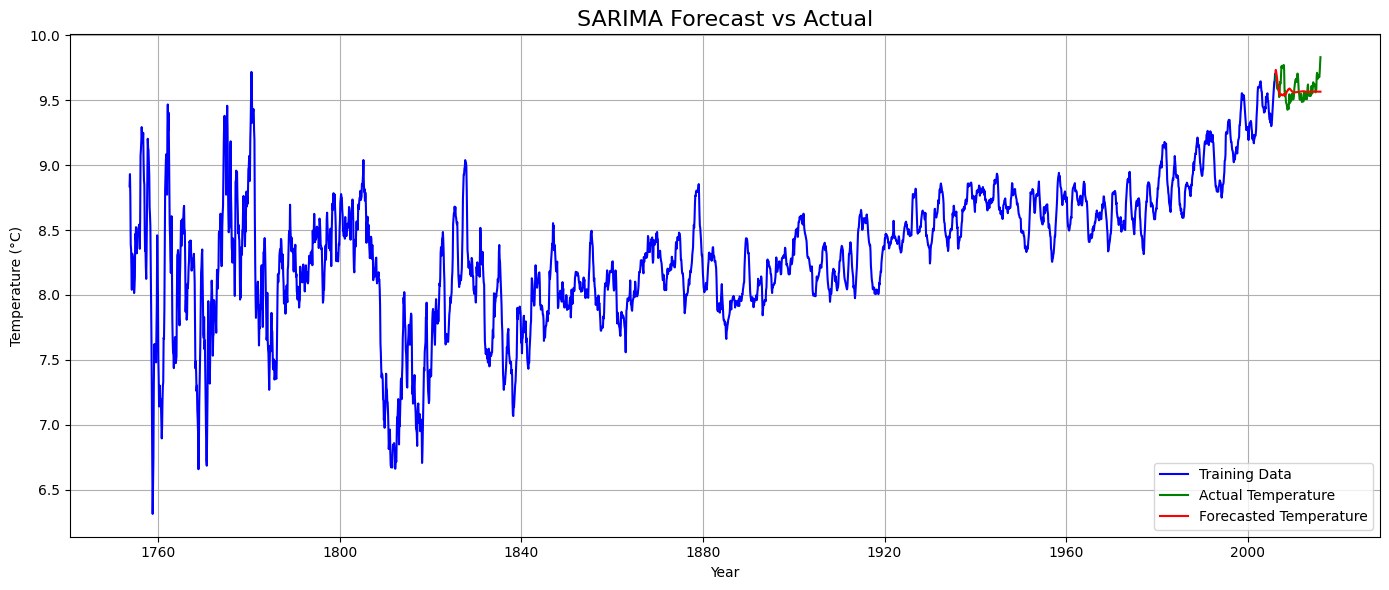

In [11]:
# 14. Forecast for test period
forecast = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# 15. Plot forecast
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Temperature', color='green')
plt.plot(test.index, forecast, label='Forecasted Temperature', color='red')
plt.title('SARIMA Forecast vs Actual', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# 16. Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f} °C')


Root Mean Squared Error (RMSE): 0.0950 °C
